In [5]:
import cv2
import matplotlib.pyplot as plt
import os, shutil
from google.colab import drive
from google.colab.patches import cv2_imshow
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50

In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(55, 49, 3)
(224, 224, 3)


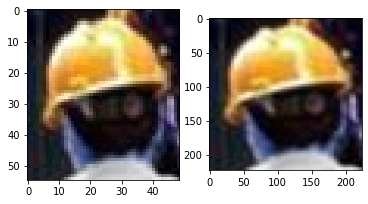

In [7]:
img=cv2.imread("/content/drive/My Drive/HardHatDataSet/train/001446_jpg.rf.00a11ab7cffb0a8fec57e98b2c4663d5.jpg")
crop_img = img[318:373, 216:265]
fig,axs=plt.subplots(1,2)
axs[0].imshow(crop_img)
print(crop_img.shape)
resized = cv2.resize(crop_img, (224, 224), interpolation = cv2.INTER_AREA)
print(resized.shape)
axs[1].imshow(resized)

In [8]:
if os.path.isdir("/content/drive/My Drive/HardHatDataSet/train/helmet_yes"):
    shutil.rmtree("/content/drive/My Drive/HardHatDataSet/train/helmet_yes")
os.mkdir("/content/drive/My Drive/HardHatDataSet/train/helmet_yes")

if os.path.isdir("/content/drive/My Drive/HardHatDataSet/train/helmet_no"):
    shutil.rmtree("/content/drive/My Drive/HardHatDataSet/train/helmet_no")
os.mkdir("/content/drive/My Drive/HardHatDataSet/train/helmet_no")

count = 0
count_head_yes_helmet=1
count_head_no_helmet=1
print("\nUsing for loop")
with open("/content/drive/My Drive/HardHatDataSet/train/_annotations.txt") as fp:
    for line in fp:
        count += 1
        data=line.strip().split()
        file_name=data[0]
        img=cv2.imread("/content/drive/My Drive/HardHatDataSet/train/"+file_name)
        for head in data[1:]:
            head_details=head.split(",")
            head_details=[int(i) for i in head_details]
            start_point = (head_details[0],head_details[1])
            end_point = (head_details[2],head_details[3])
            cropped_image=img[start_point[1]:end_point[1],start_point[0]:end_point[0]]
            dim=(224,224)
            resized = cv2.resize(cropped_image, dim, interpolation = cv2.INTER_AREA)
            has_helmet=head_details[4]
            if has_helmet:
                head_filename="/content/drive/My Drive/HardHatDataSet/train/helmet_yes/"+str(count_head_yes_helmet)+".jpg"
                count_head_yes_helmet+=1
            else:
                head_filename="/content/drive/My Drive/HardHatDataSet/train/helmet_no/"+str(count_head_no_helmet)+".jpg"
                count_head_no_helmet+=1
            cv2.imwrite(head_filename,resized)
        if count%500==0:
            print("Image file nmbr",count)
print("Number of helmet - heads = ",count_head_yes_helmet)
print("Number of no helmet - heads = ",count_head_no_helmet)



Using for loop
Image file nmbr 500
Image file nmbr 1000
Image file nmbr 1500
Image file nmbr 2000
Image file nmbr 2500
Image file nmbr 3000
Image file nmbr 3500
Image file nmbr 4000
Image file nmbr 4500
Image file nmbr 5000
Number of helmet - heads =  15358
Number of no helmet - heads =  4875


In [9]:
def load_data(path): #loads data from cropped images so they could be inputted into model
    x_train = []
    y_train = []
    yes_helmet_location=os.path.join(location,"helmet_yes")
    no_helmet_location=os.path.join(location,"helmet_no")
    yes_helmet_files=os.listdir(yes_helmet_location)
    no_helmet_files=os.listdir(no_helmet_location)
    
    for ffile in yes_helmet_files[:5000]: 
        img=cv2.imread(os.path.join(yes_helmet_location,ffile))
        tr_x = image.img_to_array(img)
        tr_x = preprocess_input(tr_x)
        x_train.append(img)
        y_train.append(1)
    for ffile in no_helmet_files:
        img=cv2.imread(os.path.join(no_helmet_location,ffile))
        tr_x = image.img_to_array(img)
        tr_x = preprocess_input(tr_x)
        x_train.append(img)
        y_train.append(0)
    return np.array(x_train), to_categorical(y_train)

location="/content/drive/My Drive/HardHatDataSet/train/"
x_train, y_train = load_data(location)

print(type(y_train))
print(y_train.shape)    # 808,4
print(x_train.shape)    # 808,299,299,3

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

<class 'numpy.ndarray'>
(9874, 2)
(9874, 224, 224, 3)
(6615, 224, 224, 3) (3259, 224, 224, 3)
(6615, 2) (3259, 2)


In [ ]:
base_model = ResNet50(input_shape=(224, 224,3), 
                      include_top=False, 
                      weights="imagenet",
                      pooling="max")

for l in base_model.layers:
    l.trainable = False

input = Input(shape=(224, 224, 3))
t = base_model(input)
output = Dense(2, activation="sigmoid")(t)
optimizer = tf.keras.optimizers.SGD(lr=0.0001)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]

model = Model(inputs=input, outputs=output)

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary

batch_size = 48
n_epochs = 100

# Callbacks
es_callback = EarlyStopping(monitor='val_loss', patience=25) #Stop training after val_loss stops moving for 25 epochs
lr_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
) #Optimises training time and effort if val_loss plateaus

history = model.fit(
    x_train,y_train, validation_data=(x_test,y_test), 
    batch_size=batch_size,
    epochs=n_epochs, callbacks=[es_callback, lr_callback]
)

model.save("/content/drive/My Drive/hard_hat_resnet50_v3.h5")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
138/138 [==============================] - 30s 133ms/step - loss: 1.2082 - accuracy: 0.6978 - val_loss: 0.9215 - val_accuracy: 0.7600 - lr: 1.0000e-04
Epoch 2/100
138/138 [==============================] - 16s 117ms/step - loss: 0.7890 - accuracy: 0.8024 - val_loss: 0.7267 - val_accuracy: 0.8190 - lr: 1.0000e-04
Epoch 3/100
138/138 [==============================] - 16s 119ms/step - loss: 0.6493 - accuracy: 0.8413 - val_loss: 0.6254 - val_accuracy: 0.8493 - lr: 1.0000e-04
Epoch 4/100
138/138 [==============================] - 16s 116ms/step - loss: 0.5646 - accuracy: 0.8615 - val_loss: 0.5603 - val_accuracy: 0.8641 - lr: 1.0000e-04
Epoch 5/100
138/138 [==============================] - 16s 117ms/step - loss: 0.5072 - accuracy: 0.8771 - val_loss: 0.5181 - val_accuracy: 0.8745 - lr: 1.0000e-04
Epoch 6/100
138/138 [==============================] - 16s 116ms/step - loss: 0.4651 - accuracy: 0.8841 - val_loss: 0.4774 - val_accuracy: 0.8794 - lr: 1.0000e-04
Epoch 7/100
138/138 [=

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
model.save("/content/drive/My Drive/hard_hat_resnet50_v2.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Testing

In [10]:
if os.path.isdir("/content/drive/My Drive/HardHatDataSet/test/helmet_yes"):
    shutil.rmtree("/content/drive/My Drive/HardHatDataSet/test/helmet_yes")
os.mkdir("/content/drive/My Drive/HardHatDataSet/test/helmet_yes")

if os.path.isdir("/content/drive/My Drive/HardHatDataSet/test/helmet_no"):
    shutil.rmtree("/content/drive/My Drive/HardHatDataSet/test/helmet_no")
os.mkdir("/content/drive/My Drive/HardHatDataSet/test/helmet_no")

count = 0
count_head_yes_helmet=1
count_head_no_helmet=1
print("\nUsing for loop")
with open("/content/drive/My Drive/HardHatDataSet/test/_annotations.txt") as fp:
    for line in fp:
        count += 1
        data=line.strip().split()
        file_name=data[0]
        img=cv2.imread("/content/drive/My Drive/HardHatDataSet/test/"+file_name)
        for head in data[1:]:
            head_details=head.split(",")
            head_details=[int(i) for i in head_details]
            start_point = (head_details[0],head_details[1])
            end_point = (head_details[2],head_details[3])
            cropped_image=img[start_point[1]:end_point[1],start_point[0]:end_point[0]]
            dim=(224,224)
            resized = cv2.resize(cropped_image, dim, interpolation = cv2.INTER_AREA)
            has_helmet=head_details[4]
            if has_helmet:
                head_filename="/content/drive/My Drive/HardHatDataSet/test/helmet_yes/"+str(count_head_yes_helmet)+".jpg"
                count_head_yes_helmet+=1
            else:
                head_filename="/content/drive/My Drive/HardHatDataSet/test/helmet_no"+str(count_head_no_helmet)+".jpg"
                count_head_no_helmet+=1
            cv2.imwrite(head_filename,resized)
        if count%500==0:
            print("Image file nmbr",count)
print("Number of helmet - heads = ",count_head_yes_helmet)
print("Number of no helmet - heads = ",count_head_no_helmet)



Using for loop
Image file nmbr 500
Image file nmbr 1000
Image file nmbr 1500
Number of helmet - heads =  5006
Number of no helmet - heads =  1804


In [11]:
model=load_model("/content/drive/My Drive/hard_hat_resnet50_v2.h5")
x_tester, y_tester = load_data("/content/drive/My Drive/HardHatDataSet/test/")
model.evaluate(x_tester,y_tester)

309/309 [==============================] - 25s 54ms/step - loss: 0.1595 - accuracy: 0.9561


[0.15949535369873047, 0.9561474323272705]

Converting to TFlite to deploy to edge

In [12]:
!pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/
     |████████████████████████████████| 2.2 MB 4.3 MB/s 


In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp7a44ooah/assets


In [14]:
with open("/content/drive/My Drive/HardHatTFLITE/hard_hat_classifier_resnot50_v2.tflite", "wb") as f:
  f.write(tflite_model)

Testing TFLite model

In [16]:
import tflite_runtime.interpreter as tflite
import tflite_runtime

In [18]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/My Drive/HardHatTFLITE/hard_hat_classifier_resnot50_v2.tflite")
interpreter.allocate_tensors()

In [19]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

Testing

In [46]:
input_test_false = cv2.imread("/content/drive/My Drive/obama.jpg")
input_test_true = cv2.imread("/content/drive/My Drive/hardhatyes.jfif")
input_shape = input_details[0]['shape']

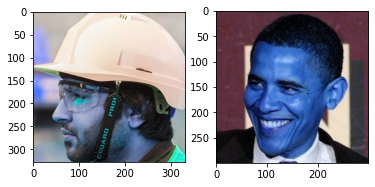

In [47]:
fig,axs=plt.subplots(1,2)
axs[0].imshow(input_test_true) #Plots picture of person wearing a hard hat
axs[1].imshow(input_test_false) #Plots picture of person not wearing a hard hat

In [50]:
print(input_test_true.shape) #Prints shape of image in numpyarray form
print(input_test_false.shape)

(328, 332, 3)
(300, 300, 3)


In [51]:
input_test_true = cv2.resize(input_test_true, (224,224), interpolation = cv2.INTER_AREA)
input_test_false = cv2.resize(input_test_false, (224,224), interpolation = cv2.INTER_AREA)

In [53]:
input_test_true = input_test_true.astype("float32")
input_test_false = input_test_false.astype("float32")

In [52]:
input_test_true = np.expand_dims(input_test_true, axis=0)
input_test_false = np.expand_dims(input_test_false, axis=0)

In [54]:
print(input_test_true.shape) #Prints shape of image in numpyarray form
print(input_test_false.shape)

(1, 224, 224, 3)
(1, 224, 224, 3)


Testing image where hard hat exists

In [55]:
#Set the value of Input tensor
interpreter.set_tensor(input_details[0]['index'], input_test_true)
interpreter.invoke()

In [56]:
#prediction for input data
output_data = interpreter.get_tensor(output_details[0]['index'])
pred = output_data[0][1] * 100 #prediction probability

In [57]:
print("Prediction = ", pred)

99.99562501907349


Testing image where there is no hard hat

In [58]:
#Set the value of Input tensor
interpreter.set_tensor(input_details[0]['index'], input_test_false)
interpreter.invoke()

In [59]:
#prediction for input data
output_data = interpreter.get_tensor(output_details[0]['index'])
pred = output_data[0][1] * 100 #prediction probability

In [60]:
print("Prediction = ", pred)

Prediction =  0.02435445785522461
